# Music Genre Classification - Audio Data Processing

## Problem Statement
Developing a machine learning model for music genre classification from audio files is a challenging task due to the high dimensionality of audio signals and the variability of music genres. The objective of this project is to develop an accurate and scalable music genre classification model that can handle large-scale datasets and generalize well to new, unseen songs. This will involve exploring various feature extraction techniques and machine learning algorithms, evaluating the model's performance on a test set, and ultimately delivering a high-performing model that can be integrated into Spotify's music recommendation system.

## Background
As a team of data scientists working at Spotify, our mission is to enhance the user experience of our music streaming platform. One way to achieve this is to provide accurate and personalized music recommendations to our users. One crucial aspect of personalized music recommendations is accurate genre classification of music tracks. While traditional manual genre labeling can be time-consuming and often subjective, an automated model that can recognize the genre of music by analyzing its sound characteristics could be a valuable tool for our platform.

Over the years, many approaches have been developed for automatic genre classification of music, including rule-based systems, feature-based models, and deep learning-based models. While rule-based systems rely on manually defined rules, feature-based models extract relevant features from the audio signal and classify the music based on these features. Deep learning-based models, on the other hand, learn hierarchical representations of the audio signal using neural networks and can achieve state-of-the-art performance in genre classification tasks.

In recent years, deep learning-based models have shown promising results in music genre classification tasks. For instance, convolutional neural networks (CNNs) have been used to extract time-frequency representations of music signals and achieve high accuracy in genre classification tasks. 

However, there is still room for improvement in the accuracy and efficiency of music genre classification models. One key challenge is the variability and diversity of music styles and sub-genres. Moreover, the robustness of these models to background noise, compression artifacts, and other forms of audio degradation is also an important consideration in real-world scenarios.

Therefore, our goal as a data science team at Spotify is to develop an accurate and robust music genre classification model that can improve the music recommendation system on our platform and enhance the user experience.

## Contents
- [Problem Statement](#Problem-Statement)
- [Background](#Background)
- [Datasets](#Datasets)
- [Imports](#Imports)
- [Functions](#Functions)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Data Collection & Processing](#Data-Collection-\&-Processing)
- [Save Collected Data](#Save-Collected-Data)
- [Data Collection Summary](#Data-Collection-Summary)

## Datasets
The raw audio dataset is provided from [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) and are organized into genre subfolders. Each genre has its own folder that consists of one-hundred 30-sec samples of music.

### Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import json
import scipy
import librosa

### Functions
- The series of functions below helps to both process and visualize the audio data.

In [2]:
def plot_waveform(audio, fs):
    """Plots the waveform of audio in the time domain.
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        
    """
    plt.figure(figsize = (12, 6))
    librosa.display.waveshow(audio, sr=fs, alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

In [3]:
def calc_spec_db(audio, kind='mag'):
    """Calculates the spectrum of an audio signal.
    
    Parameters:
        audio (numpy.ndarray): audio signal
        kind (str): type of spectrum to calculate
            - 'mag' = magnitude spectrum (real values)
            - 'phs' = phase spectrum (imaginary values)
            - 'com' = complex spectrum (both magnitude and phase)
    Returns:
        spec_db (numpy.ndarray) = the audio spectrum in db scale (re 20 μPa)
    """
    spec = scipy.fft.fft(x=audio)
    
    if kind.lower() == 'm' or 'mag' or 'magnitude':
        spec_db = 20*np.log10(np.abs(spec))
    elif kind.lower() == 'p' or 'pha' or 'phase':
        spec_db = 20*np.log10(np.imag(spec))
    elif kind.lower() == 'c' or 'com' or 'complex':
        spec_db = 20*np.log10(spec)
        
    return spec_db

In [4]:
# Function to plot spectrum
def plot_spec(audio, fs, kind='mag'):
    """Plots the magnitude spectrum of an audio signal/
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        kind (str): type of spectrum to calculate
            - 'mag' = magnitude spectrum (real values)
            - 'phs' = phase spectrum (imaginary values)
            - 'com' = complex spectrum (both magnitude and phase)
    """
    # Calculate fft
    spec_db = calc_spec_db(audio, kind=kind)
    f_axis = np.linspace(0, fs, len(spec_db))#, endpoint=False) # create 
    
    # Only take frequencies below nyquist frequency (i.e. fs/2)
    f_axis = f_axis[:int(len(spec_db)/2)]
    spec_db = spec_db[:int(len(spec_db)/2)]
    
    # Plot
    ax = plt.figure(figsize = (12, 6))
    plt.plot(f_axis, spec_db, alpha=1.0)
    plt.xscale('log')
    plt.xlim(1, fs/2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    if fs < 44100:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000], 
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K"])
    else:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000, 20000], 
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K", "20k"])

In [5]:
def calc_stft(audio, fs, n_fft=2048, hop_length=512, dB=True):
    """Calculate the sfort-time-fourier-transform over an audio signal
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        dB (str):
            - True: Convert to dB scale (aka log scale)
            - False: Do not convert to dB (aka linear scale)
    
    Returns:
        stft (numpy.ndarray): Short-time Fourier Transform of the audio signal (i.e. frequency domain data)
    """
    # Calculate STFTs (Short-time Fourier transform) over full audio length
    # absolute value to calculate magnitude (drop imag values)
    stft = np.abs(librosa.stft(y=audio, n_fft=n_fft, hop_length=hop_length))
    
    # Convert to dB (aka log-scale)
    if dB:
        stft = librosa.amplitude_to_db(stft, ref=np.max) # ref - set max to 0 dB

    return stft

In [6]:
def plot_spectrogram(audio, fs, n_fft=2048, hop_length=512, dB=True, fig_size=(12,6)):
    """Plots audio spectrogram.
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        dB (str):
            - True: Convert to dB scale (aka log scale)
            - False: Do not convert to dB (aka linear scale)
        fig_size (tuple): Dimensions of figure
    """
    # Calculate STFTs
    stft_db = calc_stft(audio, fs, n_fft=n_fft, hop_length=hop_length, dB=dB)
    
    plt.figure(figsize=fig_size)
    librosa.display.specshow(data=stft_db, sr=fs, x_axis='time', y_axis='log', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('Spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout();

In [8]:
def calc_mel_spec(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512):
    """calculates the Mel-scaled spectrogram.
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames

    Returns:
        mel_spec_db (numpy.ndarray): Mel-scaled spectrogram in dB
    """
    # Mel-scaled power spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=fs, n_mels=n_mfccs, n_fft=n_fft, hop_length=hop_length)

    # Convert to dB (aka log-scale)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max) # ref - set max to 0 dB
    
    return mel_spec_db

In [9]:
def plot_mel_spectrogram_audio(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from audio signal.
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        fig_size (tuple): Dimensions of figure
    """
    # Calculate mel-spectrogram
    mel_spec_db = calc_mel_spec(audio, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length)
    
    # Plot Spectrogram
    plt.figure(figsize=fig_size)
    librosa.display.specshow(data=mel_spec_db, sr=fs, x_axis='time', y_axis='mel', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('Mel Power Spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

In [10]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.
    
    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)
    
    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    
    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

## Exploratory Data Analysis (EDA)

### Load Data Sample
- Here we will load in a sample files of audio data to explore what it looks like and how it can be transformed.

In [13]:
path_data = r'D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/data/'
genre = 'ambient/'
filename = 'antent - never see you again.mp3'

file_path = path_data + genre + filename

In [14]:
fs = 22050 # sampling rate for librosa to resample to
audio_ex, fs = librosa.load(path=file_path, sr=fs) # load audio and sampling rate

C:\Users\ADVAN\AppData\Local\Temp\ipykernel_13548\2111896850.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_ex, fs = librosa.load(path=file_path, sr=fs) # load audio and sampling rate
c:\Users\ADVAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


### Waveform
- The waveform of the data shows the oscillations of pressure amplitude over time. This is effectively a "raw" format of audio data.
- It is defined by the sampling frequency and bit depth.
    - The sampling frequency refers to how many samples of audio are played back per second (i.e. 44.1kHz means that every second, 44,100 samples are played). This determines the upper bound of frequencies that can be represented by the audio signal.
    - The bit depth refers to how precise the amplitude values are determining the dynamic range of an audio signal (i.e. 16-bit depth can represent 65,536 unique numbers, resulting in approx. 96dB of dynamic range)
- To simplify, the sampling rate essentially controls the resolution of the x-axis and the bit depth controls the resolution of the y-axis

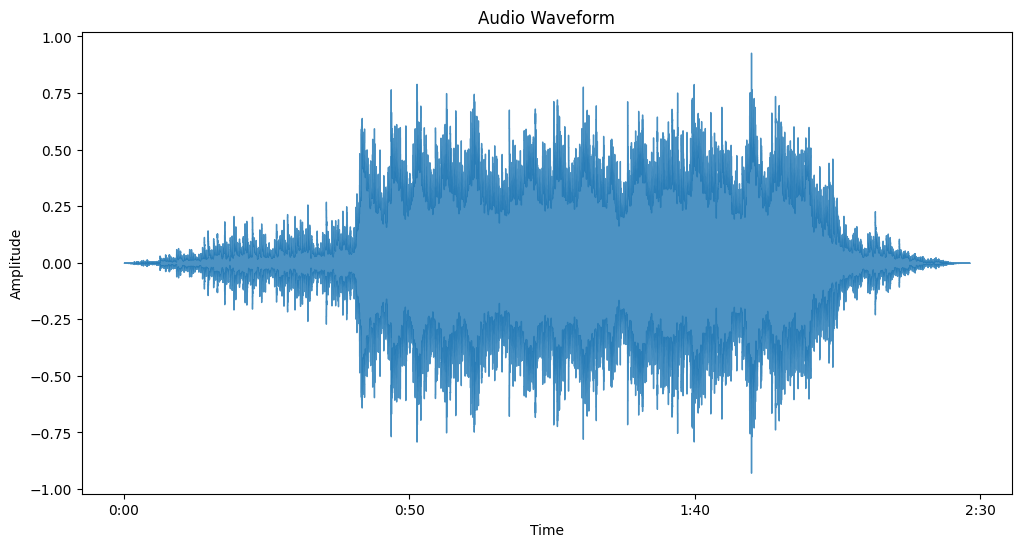

In [15]:
# Create time axis
plot_waveform(audio_ex, fs);
plt.title('Audio Waveform');

### Frequency Spectrum
- The spectrum of a waveform shows the magnitude (in dB) of the signal per frequency.
- Notice there is no time component here, rather the magnitude (dB) is with reference to frequencies of the entire audio signal (in this case 30 sec clip)
- While the plot below shows the spectrum for the entire signal, we will be using this concept to take the spectrum of small pieces of the signal to reintroduce a time component when we create spectrograms next.

C:\Users\ADVAN\AppData\Local\Temp\ipykernel_13548\2472364205.py:16: RuntimeWarning: divide by zero encountered in log10
  spec_db = 20*np.log10(np.abs(spec))


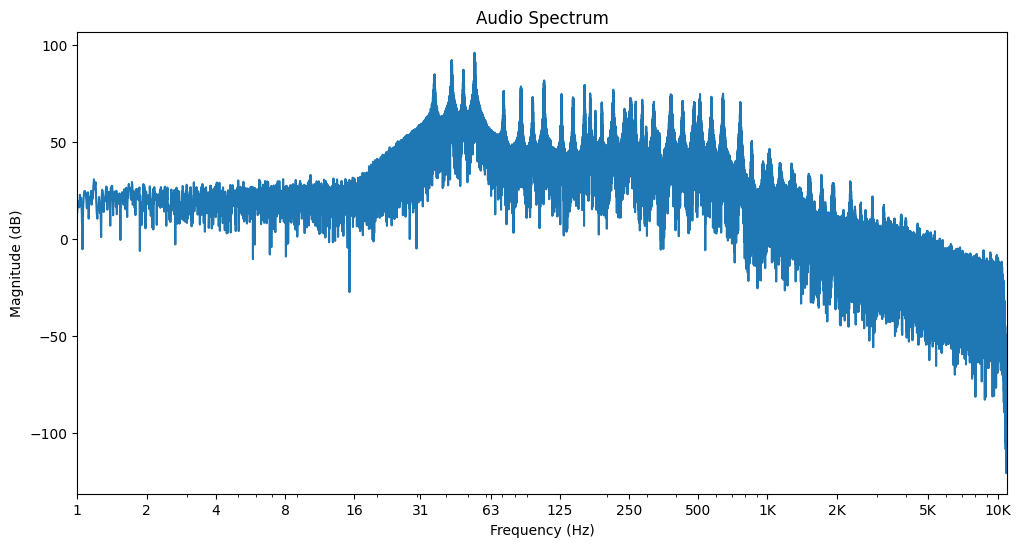

In [16]:
plot_spec(audio_ex, fs)
plt.title('Audio Spectrum');

### Spectrogram
- A spectrogram is the combination of a waveform and spectrum plot, resulting in frequency magnitude (in dB) over time.
- It has been scaled so that 0 dB is the maximum value.
- Notice how patterns emerge in the light-green and yellow, looking like diagonal lines that move up and down. These patterns correspond to specific attributes of the music, such as melodies.

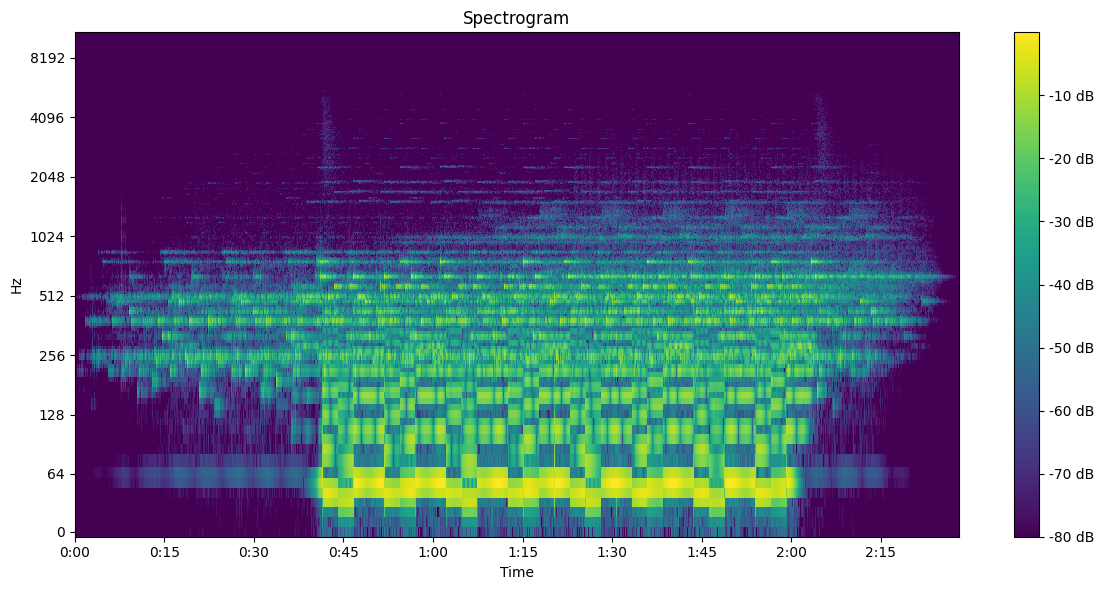

In [17]:
# Plot Spectrogram
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns
dB = True # True for dB scale
plot_spectrogram(audio_ex, fs, n_fft=n_fft, dB=dB, hop_length=hop_length)

### Mel-Spectrogram
- The Mel-spectrogram is similar to a spectrogram, except that the magnitudes have been scaled to a "Mel-scale".
- This "Mel-scale" can be summarized with Mel Frequency Cepstral Coefficients (MFCCs).
- This is used in many machine learning cases because it filters the data more closely to how humans hear and it provides a better format of the data for the algorithm to learn on.
- Additionally, the resolution can be drastically reduced and still retain important information. This can be thought of as a form of compressing the audio data.

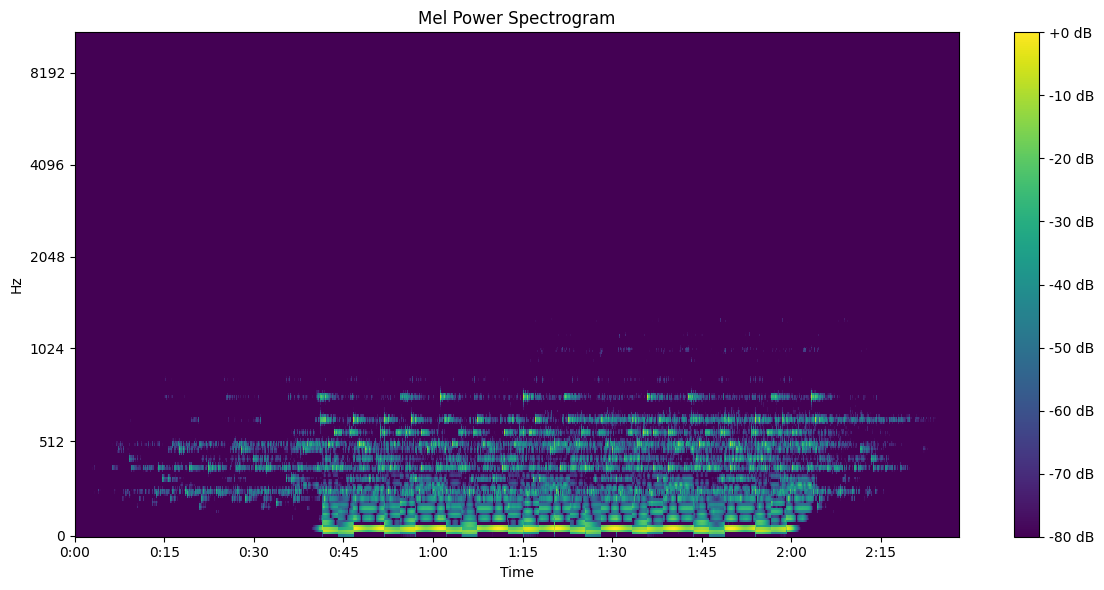

In [18]:
# Plot Mel-Spectrogram
n_mfccs = 256 # number of mel coeffs
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns
plot_mel_spectrogram_audio(audio_ex, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length, fig_size=(12,6))

## Data Collection & Processing
The data collection process consists of three steps:
- Collect audio data and genres
- Convert audio to MFCCs
- Save MFCCs and genres to disk

During this process, the audio files are split into 3-second segments. Because neural networks need a large number of samples to train on, this effectively increases the number of samples we will be able to feed into our network.

The collection process takes some time, as many audio files are read into the computer. So the MFCCs are saved to the computer for quicker importing for later reference.

In [19]:
# Load the audio files and convert them to MFCCs
# code modified from https://www.youtube.com/watch?v=szyGiObZymo&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=12
def get_mfccs(directory_path, fs=22500, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
    """Reads through a directory of audio files and saves a dictionary of MFCCs and genres to a .json file. It also returns
    numpy.ndarrays for MFCCs, genre name, and genre number for each segment of audio signal.
    
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        duration (int): duration of audio signal (sec)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        num_segments (int): number of segments for the audio signal to be broken up into
        
    Returns:
        "mfcc" (numpy.ndarray): MFCC vectors for each segment
        "genre_name" (numpy.ndarray): name of the genre for each segment (i.e. blues, classical, etc.)
        "genre_num" (numpy.ndarray): number value of the genre for each segment (i.e. 0, 1, 2, etc.)
    """
    data = {
        "genre_name": [],   # name of the genre (i.e. blues, classical, etc.)
        "genre_num": [],    # number value of the genre (i.e. 0, 1, 2, etc.)
        "mfcc": []          # the mfcc vectors
    }
    
    # Calculate the number of samples per segment and the 
    samples_per_track = fs * duration # Calculate the number of samples for desired "duration" of track
    samps_per_segment = int(samples_per_track/num_segments) # number of samples per segment
    mfccs_per_segment = math.ceil(samps_per_segment/hop_length) # number of MFCC vectors per segment
    
    # Loop through all folders & files in the data directory
        # path_current: Path to the current folder (start at outermost folder, then 'walk' in)
        # folder_names: List of names of all folders within the current folder
        # file_names: names List of names of all files within the current folder
        # i: index of current iteration
    print("MFCC collection started!")
    print("========================")
    for i, (path_current, folder_names, file_names) in enumerate(os.walk(directory_path)):
        
        # Check to make sure that the current folder is not the parent folder
        if path_current is not directory_path:
        
            # Save 
            path_list = path_current.split('/') # split the path into a list
            genre_current = path_list[-1] # select last item in path list (name of folder = genre)
            
            # Loop through files for each genre (sub-directory)
            for file in file_names:
                
                # Load audio data
                file_path = os.path.join(path_current, file).replace(os.sep, '/') # create audio file path

                # try/except to skip a few files that create issues
                try:
                    # Load audio data and sampling frequency
                    audio, fs = librosa.load(file_path, sr=fs) # audio in samples, sampling rate

                    # Loop through audio file for specified number of segments to calculate MFCCs
                    for seg in range(num_segments):

                        # Calculate the samples to bound each segment
                        start_sample = seg * samps_per_segment # segment starting sample
                        end_sample = start_sample + samps_per_segment # segment ending sample

                        # Calculate segment MFCC
                        mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample],    # audio signal
                                                    sr=fs,                               # sampling rate (Hz)
                                                    n_fft=n_fft,                         # fft window size
                                                    hop_length=hop_length,               # hop size
                                                    n_mfcc=n_mfcc)                       # number of mfccs to compute

                        mfcc = mfcc.T # transpose for appropriate list appending

                        # Confirm correct number of mfccs for each segment, then append
                        if len(mfcc) == mfccs_per_segment:
                            data["genre_name"].append(genre_current) # append current genre to list of genres
                            data["genre_num"].append(i-1) # append current genre to list of genres
                            data["mfcc"].append(mfcc.tolist()) # append current mfcc to list of mfccs
                except:
                    continue

            # Print update status
            print(f"Collected MFCCs for {genre_current.title()}!")
    
    with open(r'D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/data/data.json', "w") as filepath:
        print("========================")
        print("Saving data to disk...")
        json.dump(data, filepath, indent=4)
        print("Saving complete!")
        print("========================")
    
    # option to return MFCCs and genres
    return np.array(data["mfcc"]), np.array(data["genre_name"]), np.array(data["genre_num"])

#### Collect and Compute MFCCs

In [20]:
%%time
# Set up the parameters for the MFCC conversion
n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 10 # split teack into 10 segments (3 sec each)
track_duration = 30 # Length of tracks (sec)

directory_path = r'D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/data/'
mfccs, genres, genre_nums = get_mfccs(directory_path,
                          fs=fs,
                          duration=track_duration,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          n_mfcc=n_mfcc, 
                          num_segments=num_segments)

MFCC collection started!


C:\Users\ADVAN\AppData\Local\Temp\ipykernel_13548\1476749690.py:57: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file_path, sr=fs) # audio in samples, sampling rate
c:\Users\ADVAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Collected MFCCs for Ambient!
Collected MFCCs for Pop!
Collected MFCCs for Pop!
Collected MFCCs for Rock!
Saving data to disk...
Collected MFCCs for Rock!
Saving data to disk...
Saving complete!
CPU times: total: 58.4 s
Wall time: 1min 2s
Saving complete!
CPU times: total: 58.4 s
Wall time: 1min 2s


In [21]:
# Review mfccs and genres for the correct shape
print(f"MFCCs: {mfccs.shape}")
print(f"genres: {genres.shape}")

MFCCs: (910, 130, 13)
genres: (910,)


In [22]:
# Map target genre to number
# 3 classes: ambient (0), pop (1), rock (2)
genre_map = dict(zip(sorted(set(genres)), np.arange(0, 3)))
genres_num = np.array(pd.Series(genres).map(genre_map))
# list(zip(genres_num, genres)) # view mapped target

### Plot MFCC
We looked at a Mel-Spectrogram earlier, but the resolution was still quite high. Here another Mel-spectrogram is plotted using the MFCCs that we calculated and it demonstrates how much the data has been compressed. While we may no longer be able to spot trends in the data, this is still a sufficient (and much smaller) format for a neural network to learn on.

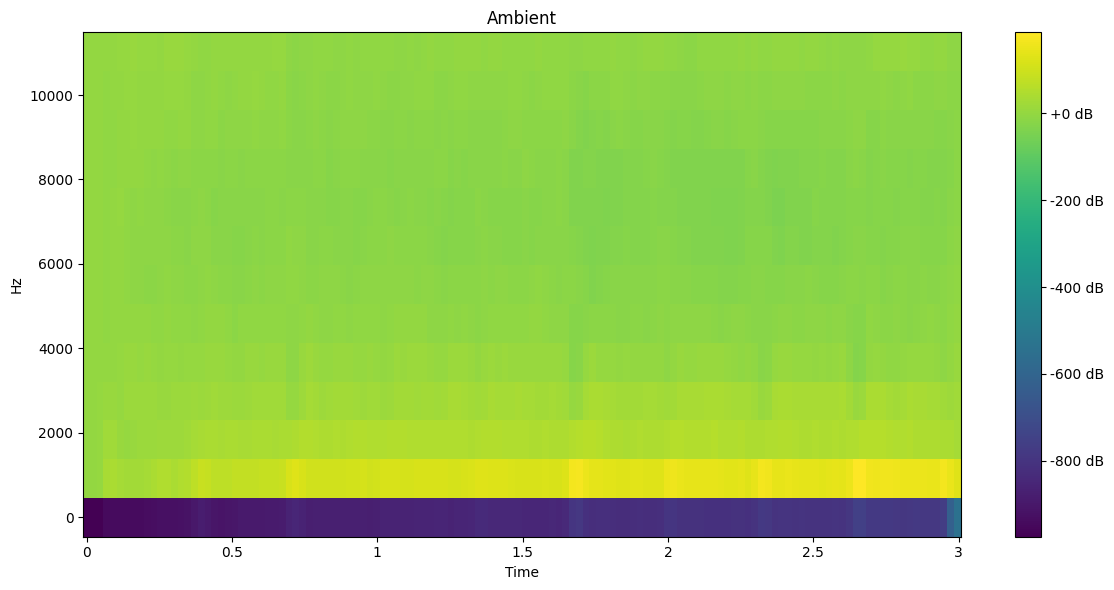

In [23]:
# Plot an MFCC example
idx = 0
plot_mfcc(mfccs[idx].T, fs)
plt.title(f"{genres[idx].title()}");

### Data Collection Summary
- In this notebook we reviewed audio data and how it can be viewed and transformed.
- We also collected audio data, transformed it into MFCCs, and saved the data.
- In the next notebook, we will use the data we have processed here to train neural networks.